In [8]:
import scipy.io
data = scipy.io.loadmat('Data_ankle.mat')
ankle_data= data['ankle_data']
print(ankle_data.shape)

(48000, 7)


In [9]:
import pandas as pd

### Load in DataFrame

In [10]:
# Define column names
column_names = [
    'time', 
    'vgrf',  # vertical ground reaction force
    'trunk_angle',
    'hip_angle', 
    'knee_angle', 
    'ankle_angle', 
    'joint_moment'
]
df = pd.DataFrame(ankle_data, columns=column_names )
df.head()

,time,vgrf,trunk_angle,hip_angle,knee_angle,ankle_angle,joint_moment
0,0.00,-10.321381,-0.094286,0.292974,0.825063,-1.492588,-2.011628
1,0.01,-7.990312,-0.096174,0.293179,0.822469,-1.493192,-3.655209
2,0.02,-6.208738,-0.096449,0.294008,0.810997,-1.495867,-5.786433
3,0.03,-5.126637,-0.097196,0.295568,0.785731,-1.501793,-6.190008
4,0.04,-4.774037,-0.095624,0.297472,0.745707,-1.511208,-5.542868


In [44]:
df.describe()


,time,vgrf,trunk_angle,hip_angle,knee_angle,ankle_angle,joint_moment
count,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000
mean,239.995000,355.143317,-0.051574,0.087569,0.461276,-1.557203,31.054144
std,138.565508,313.909396,0.042220,0.176258,0.325162,0.151105,36.939725
min,0.000000,-28.749562,-0.148580,-0.239775,0.019355,-1.862011,-15.414847
25%,119.997500,-3.361821,-0.084834,-0.082198,0.230068,-1.685668,-0.004131
50%,239.995000,437.072999,-0.059513,0.117106,0.328396,-1.571418,12.770055
75%,359.992500,652.307594,-0.017608,0.258930,0.670041,-1.474308,57.552954
max,479.990000,883.175946,0.071489,0.358529,1.209329,-1.138431,125.762815


### Normalize the DataSet

In [11]:
from sklearn.preprocessing import MinMaxScaler

# Features and targets
features = df.drop(columns=['joint_moment'])
targets = df['joint_moment']

# Normalize features
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(features)
normalized_features_df = pd.DataFrame(normalized_features, columns=features.columns)
print(normalized_features_df.head())

       time      vgrf  trunk_angle  hip_angle  knee_angle  ankle_angle
0  0.000000  0.020208     0.246712   0.890431    0.677080     0.510548
1  0.000021  0.022764     0.238134   0.890774    0.674900     0.509714
2  0.000042  0.024718     0.236884   0.892159    0.665259     0.506018
3  0.000063  0.025904     0.233489   0.894766    0.644027     0.497827
4  0.000083  0.026291     0.240635   0.897949    0.610393     0.484816


### Train Test Split

In [12]:
train_size = int(0.8 * len(normalized_features_df))
train_features = normalized_features_df.iloc[:train_size]
test_features = normalized_features_df.iloc[train_size:]
train_targets = targets.iloc[:train_size]
test_targets = targets.iloc[train_size:]

### NN models

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten

def create_cnn_model(input_shape):
    model = Sequential()
    # Add padding='same' to prevent excessive downsampling
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', padding='same', input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1))  # Output layer for joint moment prediction
    model.compile(optimizer='adam', loss='mse')
    return model

In [14]:
from tensorflow.keras.layers import LSTM

def create_rnn_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=input_shape))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1))  # Output layer for joint moment prediction
    model.compile(optimizer='adam', loss='mse')
    return model

### TRAINing

In [22]:
from sklearn.metrics import mean_squared_error

# Function to train and evaluate models
def train_and_evaluate_model(train_features, test_features, train_targets, test_targets, model_fn, input_shape):
    # Prepare data for the model
    train_features_reshaped = train_features.values.reshape((train_features.shape[0], *input_shape))
    test_features_reshaped = test_features.values.reshape((test_features.shape[0], *input_shape))
    
    # Create and train model
    model = model_fn(input_shape)
    model.fit(train_features_reshaped, train_targets, epochs=50, batch_size=32, validation_split=0.2)
    predictions = model.predict(test_features_reshaped).flatten()
    
    # Calculate metrics
    mse = mean_squared_error(test_targets, predictions)
    
    return mse, predictions

# Define input combinations
input_combinations = {
    'ankle_angle_only': ['ankle_angle'],
    'ankle_angle_and_vgrf':['vgrf','ankle_angle',],
    'all_joint_angles': ['trunk_angle', 'hip_angle', 'knee_angle', 'ankle_angle'],
    'all_angles_and_vgrf': ['vgrf', 'trunk_angle', 'hip_angle', 'knee_angle', 'ankle_angle']
}

# Evaluate different input combinations
results = {}

for key, columns in input_combinations.items():
    # CNN
    cnn_mse, cnn_predictions = train_and_evaluate_model(
        train_features[columns], 
        test_features[columns], 
        train_targets, 
        test_targets, 
        create_cnn_model, 
        (len(columns), 1)
    )
    
    # RNN
    rnn_mse, rnn_predictions = train_and_evaluate_model(
        train_features[columns], 
        test_features[columns], 
        train_targets, 
        test_targets, 
        create_rnn_model, 
        (1, len(columns))
    )
    
    results[key] = {
        'cnn_mse': cnn_mse,
        'rnn_mse': rnn_mse,
        'cnn_predictions': cnn_predictions,
        'rnn_predictions': rnn_predictions
    }
    
    print(f"Input Combination: {key}")
    print(f"CNN - MSE: {cnn_mse}")
    print(f"RNN - MSE: {rnn_mse}")

Epoch 1/50
960/960 [==============================] - 1s 592us/step - loss: 1057.0729 - val_loss: 217.3691
Epoch 2/50
960/960 [==============================] - 1s 577us/step - loss: 226.5997 - val_loss: 210.0455
Epoch 3/50
960/960 [==============================] - 1s 527us/step - loss: 224.6650 - val_loss: 209.2584
Epoch 4/50
960/960 [==============================] - 0s 480us/step - loss: 224.4026 - val_loss: 210.1028
Epoch 5/50
960/960 [==============================] - 0s 485us/step - loss: 224.4044 - val_loss: 209.8436
Epoch 6/50
960/960 [==============================] - 0s 464us/step - loss: 224.0712 - val_loss: 209.9753
Epoch 7/50
960/960 [==============================] - 1s 521us/step - loss: 223.6152 - val_loss: 209.5023
Epoch 8/50
960/960 [==============================] - 0s 497us/step - loss: 223.4886 - val_loss: 207.8366
Epoch 9/50
960/960 [==============================] - 0s 473us/step - loss: 223.4842 - val_loss: 209.2287
Epoch 10/50
960/960 [========================

In [31]:
mse_values = {key: {'cnn_mse': result['cnn_mse'], 'rnn_mse': result['rnn_mse']} for key, result in results.items()}
print(mse_values)

{'ankle_angle_only': {'cnn_mse': 211.02418993250922, 'rnn_mse': 211.85793263672176}, 'ankle_angle_and_vgrf': {'cnn_mse': 114.74574884491037, 'rnn_mse': 134.57226068968882}, 'all_joint_angles': {'cnn_mse': 21.503166995131004, 'rnn_mse': 17.450426364643274}, 'all_angles_and_vgrf': {'cnn_mse': 10.898508247378047, 'rnn_mse': 9.903270722947374}}


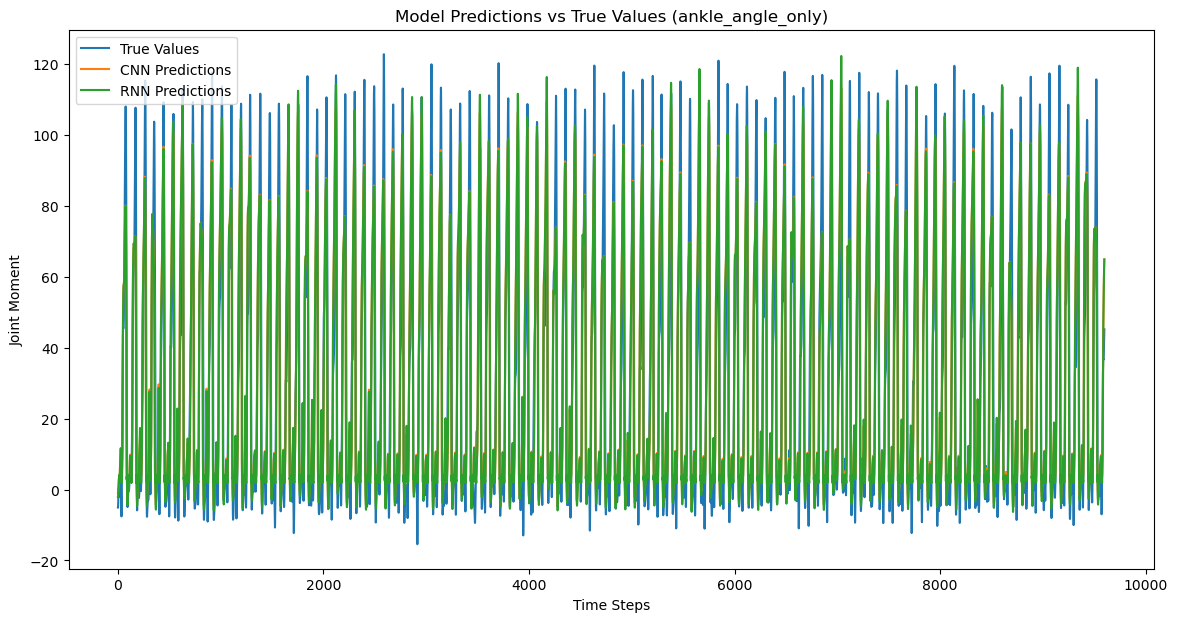

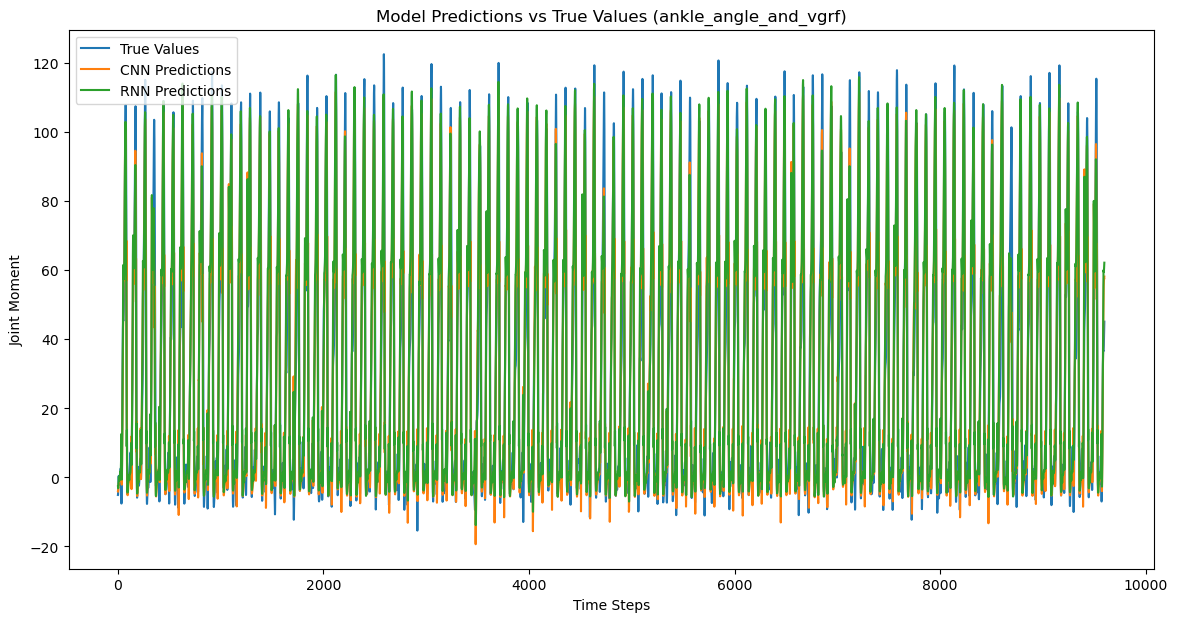

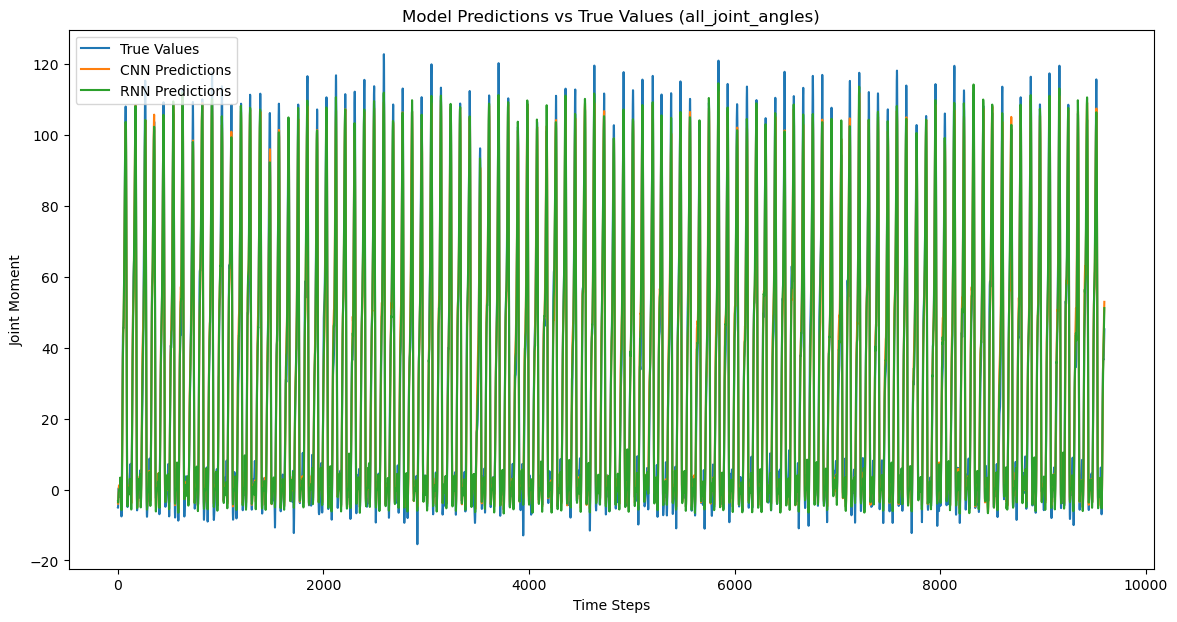

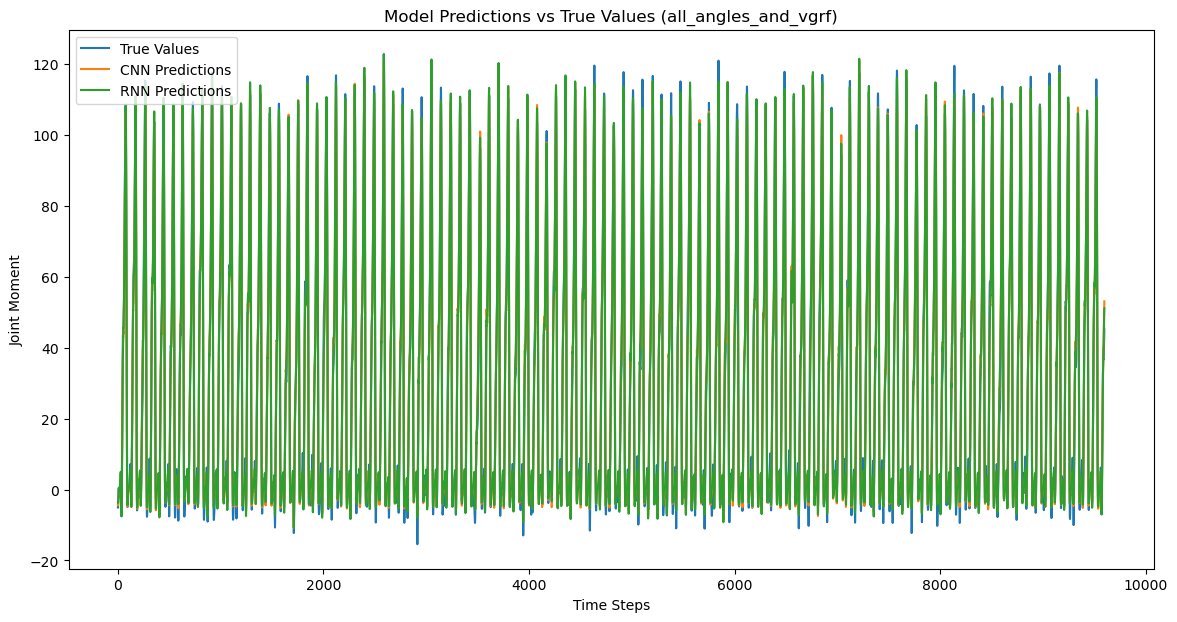

In [32]:
import matplotlib.pyplot as plt

for key, result in results.items():
    plt.figure(figsize=(14, 7))
    plt.plot(test_targets.values, label='True Values')
    plt.plot(result['cnn_predictions'], label='CNN Predictions')
    plt.plot(result['rnn_predictions'], label='RNN Predictions')
    plt.xlabel('Time Steps')
    plt.ylabel('Joint Moment')
    plt.title(f'Model Predictions vs True Values ({key})')
    plt.legend()
    plt.show()

In [35]:
print(results['ankle_angle_and_vgrf']['rnn_predictions'])
print(test_targets)


[-2.6040118 -3.1109889 -3.1217234 ... 60.895756  61.55194   62.227043 ]
38400    -5.112922
38401    -5.135164
38402    -4.378849
38403    -3.180236
38404    -1.864921
           ...    
47995    39.358802
47996    40.964877
47997    42.610781
47998    44.051917
47999    45.136660
Name: joint_moment, Length: 9600, dtype: float64
